https://www.learnpytorch.io/03_pytorch_computer_vision/

In [69]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchmetrics
from torchmetrics import Accuracy
from torchinfo import summary
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


from utils import plot_training_history

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

# to create val dataset split train_data using train_test_split()

In [24]:
print(train_data)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [25]:
image, label = train_data[0] # 1st train sample is a tupel of (image, label)
print(image.shape)
print(label)

torch.Size([1, 28, 28])
9


In [26]:
len(train_data)

60000

In [27]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [28]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [29]:
train_data.classes[9]

'Ankle boot'

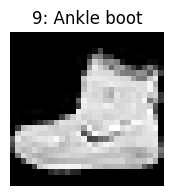

In [30]:
plt.figure(figsize=(2,2))
plt.imshow(image.squeeze(), cmap='gray') # image shape [1, 28, 28] -> [28, 28]
plt.title(f'{label}: {train_data.classes[label]}')
plt.axis(False);

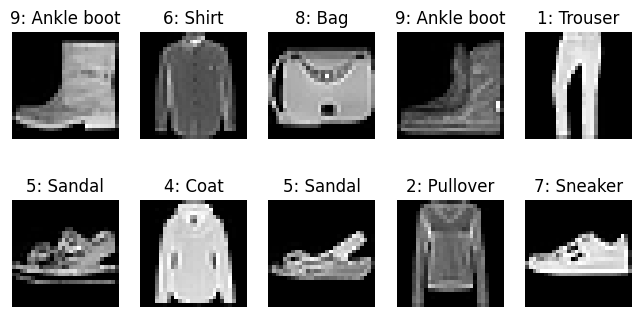

In [31]:
torch.manual_seed(42)

rows, cols = 2, 5
fig = plt.figure(figsize=(8,4))
for i in range(1, rows*cols+1):
    idx = torch.randint(0, len(train_data), size=(1,)).item() # get value from random tensor with shape [1,]
    image, label = train_data[idx]
    plt.subplot(rows, cols, i)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'{label}: {train_data.classes[label]}')
    plt.axis(False);

In [32]:
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data,
    batch_size=BATCH_SIZE, 
    shuffle=True # shuffle data every epoch
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # test data does not need to be shuffled, but can be
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [33]:
# check what is in the trainloader
train_features_batch_1, train_labels_batch_1 = next(iter(train_dataloader)) # 1st batch of train_loader
train_features_batch_2, train_labels_batch_2 = next(iter(train_dataloader)) # 2nd batch of train_loader
# etc...

print(train_features_batch_1.shape, train_labels_batch_1.shape)
train_labels_batch_1, train_labels_batch_2

torch.Size([32, 1, 28, 28]) torch.Size([32])


(tensor([3, 7, 4, 1, 1, 4, 0, 2, 7, 3, 6, 4, 9, 4, 7, 0, 9, 7, 9, 8, 3, 9, 2, 2,
         5, 3, 7, 0, 5, 9, 9, 5]),
 tensor([9, 9, 6, 4, 9, 2, 9, 4, 7, 6, 4, 3, 5, 6, 4, 5, 4, 7, 7, 5, 4, 2, 7, 3,
         0, 2, 0, 7, 9, 5, 2, 3]))

In [34]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU() # why not softmax???
        )
    
    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

In [35]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28,
    hidden_units=10,
    output_shape=len(train_data.classes)
).to(device)


In [36]:
next(model_1.parameters()).device # check model device

device(type='cpu')

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)
accuracy_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=len(train_data.classes)).to(device)

In [38]:
len(train_dataloader.dataset), len(train_dataloader)

(60000, 1875)

In [39]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device = device):
    accum_batch_loss, accum_batch_acc = 0, 0
    model.to(device)
    # model.train()
    
    for batch, (batch_X, batch_y) in enumerate(data_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        y_pred = model(batch_X)
        loss = loss_fn(y_pred, batch_y) # batch loss
        accum_batch_loss += loss * len(batch_y) 
        accum_batch_acc += accuracy_fn(y_pred.argmax(dim=1), batch_y) * len(batch_y) # batch acc * batch size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    step_train_loss = accum_batch_loss / len(data_loader.dataset)
    step_train_acc = accum_batch_acc / len(data_loader.dataset)
    print(f"Train loss: {step_train_loss:.5f} | Train accuracy: {step_train_acc:.3f}")
    return step_train_loss, step_train_acc

def test_step(data_loader, model, loss_fn, accuracy_fn, device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()

    with torch.inference_mode(): 
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            y_pred = model(batch_X)
            test_loss += loss_fn(y_pred, batch_y) * len(batch_y)
            test_acc += accuracy_fn(y_pred.argmax(dim=1), batch_y) * len(batch_y) # logits -> pred labels
        
        step_test_loss = test_loss / len(data_loader.dataset)
        step_test_acc = test_acc / len(data_loader.dataset)
        print(f"Test loss: {step_test_loss:.5f} | Test accuracy: {step_test_acc:.3f}\n")
    
    return step_test_loss, step_test_acc

In [40]:
# torch.manual_seed(42)

# epochs = 3
# for epoch in range(epochs):
#     print(f"Epoch: {epoch}\n---------")
#     train_step(data_loader=train_dataloader, 
#         model=model_1, 
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         accuracy_fn=accuracy_fn
#     )
#     test_step(data_loader=test_dataloader,
#         model=model_1,
#         loss_fn=loss_fn,
#         accuracy_fn=accuracy_fn
#     )


Epoch: 0
---------


Train loss: 1.09199 | Train accuracy: 0.613
Test loss: 0.95680 | Test accuracy: 0.650

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 0.719
Test loss: 0.72279 | Test accuracy: 0.739

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 0.759
Test loss: 0.68546 | Test accuracy: 0.750



In [41]:
# alt to cell above to gather data for visualization and use val data if available(corresponding to history)
torch.manual_seed(42)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 3
# Training and validation loop (on test data)
for epoch in range(epochs):
      print(f"Epoch: {epoch}\n---------")
      train_loss, train_accuracy = train_step(data_loader=train_dataloader, model=model_1, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
      train_losses.append(train_loss.item())
      train_accuracies.append(train_accuracy.item())
 
      val_loss, val_accuracy = test_step(data_loader=test_dataloader, model=model_1, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
      val_losses.append(val_loss.item())
      val_accuracies.append(val_accuracy.item())

# test
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model_1, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

Epoch: 0
---------


Train loss: 0.64519 | Train accuracy: 0.766
Test loss: 0.68964 | Test accuracy: 0.750

Epoch: 1
---------
Train loss: 0.62752 | Train accuracy: 0.771
Test loss: 0.66790 | Test accuracy: 0.758

Epoch: 2
---------
Train loss: 0.61555 | Train accuracy: 0.774
Test loss: 0.64630 | Test accuracy: 0.763

Test loss: 0.64630 | Test accuracy: 0.763



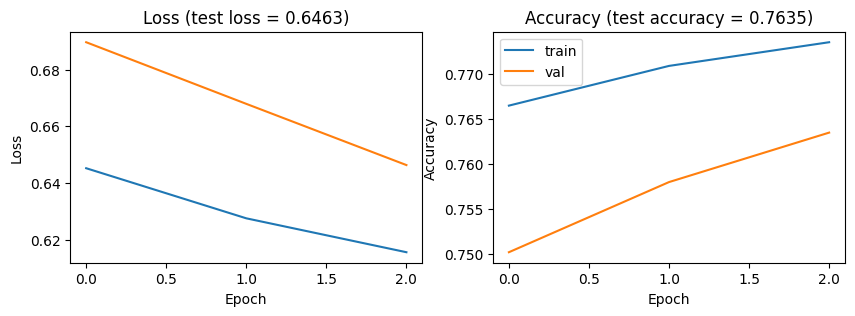

In [42]:
# visualize data
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy)

In [106]:
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, 
    hidden_units=10, 
    output_shape=len(train_data.classes)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [44]:
summary(model=model_2, 
        input_size=(32, 1, 28, 28),
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
FashionMNISTModelV2 (FashionMNISTModelV2)     [32, 1, 28, 28]      [32, 10]             --                   True
├─Sequential (block_1)                        [32, 1, 28, 28]      [32, 10, 14, 14]     --                   True
│    └─Conv2d (0)                             [32, 1, 28, 28]      [32, 10, 28, 28]     100                  True
│    └─ReLU (1)                               [32, 10, 28, 28]     [32, 10, 28, 28]     --                   --
│    └─Conv2d (2)                             [32, 10, 28, 28]     [32, 10, 28, 28]     910                  True
│    └─ReLU (3)                               [32, 10, 28, 28]     [32, 10, 28, 28]     --                   --
│    └─MaxPool2d (4)                          [32, 10, 28, 28]     [32, 10, 14, 14]     --                   --
├─Sequential (block_2)                        [32, 10, 14, 14]     [32, 10, 7, 7]       -

In [107]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [108]:
# torch.manual_seed(42)

# epochs = 3
# for epoch in range(epochs):
#     print(f"Epoch: {epoch}\n---------")
#     train_step(data_loader=train_dataloader, 
#         model=model_2, 
#         loss_fn=loss_fn,
#         optimizer=optimizer,
#         accuracy_fn=accuracy_fn,
#         device=device
#     )
#     test_step(data_loader=test_dataloader,
#         model=model_2,
#         loss_fn=loss_fn,
#         accuracy_fn=accuracy_fn,
#         device=device
#     )


In [109]:
torch.manual_seed(42)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 3
# Training and validation loop (on test data)
for epoch in range(epochs):
      print(f"Epoch: {epoch}\n---------")
      train_loss, train_accuracy = train_step(data_loader=train_dataloader, model=model_2, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
      train_losses.append(train_loss.item())
      train_accuracies.append(train_accuracy.item())
 
      val_loss, val_accuracy = test_step(data_loader=test_dataloader, model=model_2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
      val_losses.append(val_loss.item())
      val_accuracies.append(val_accuracy.item())

# test
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model_2, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

Epoch: 0
---------
Train loss: 0.59801 | Train accuracy: 0.785
Test loss: 0.40276 | Test accuracy: 0.858

Epoch: 1
---------
Train loss: 0.36574 | Train accuracy: 0.868
Test loss: 0.35819 | Test accuracy: 0.869

Epoch: 2
---------
Train loss: 0.33385 | Train accuracy: 0.879
Test loss: 0.33213 | Test accuracy: 0.881

Test loss: 0.33213 | Test accuracy: 0.881



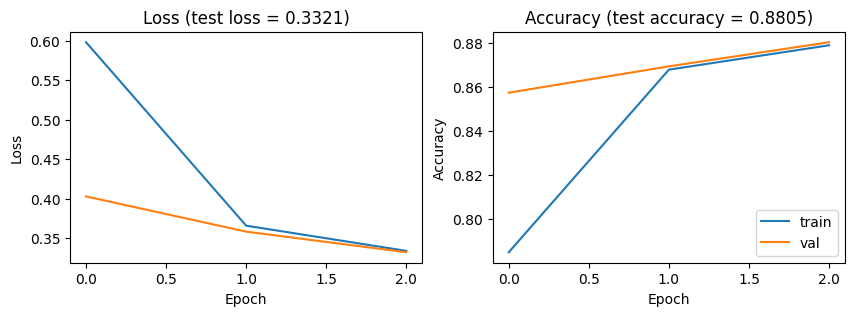

In [110]:
# visualize data
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy)

### Make predictions on a few samples and visualize

In [47]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    pred_labels = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)
            pred_probs.append(pred_prob.cpu()) # Get pred_prob off GPU for further calculations
            pred_labels.append(torch.argmax(pred_prob))
            
    return torch.stack(pred_labels) # stack: list -> tensor

In [48]:
torch.manual_seed(42)

test_images = []
test_labels = []

for i in range(9):
    idx = torch.randint(0, len(test_data), size=(1,)).item() # get value from random tensor with shape [1,]
    image, label = train_data[idx]
    test_images.append(image)
    test_labels.append(label)

In [49]:
test_labels

[1, 9, 7, 6, 0, 7, 1, 7, 4]

In [50]:
pred_labels = make_predictions(model_2, test_images, device)
pred_labels

tensor([1, 9, 7, 6, 0, 7, 1, 7, 4])

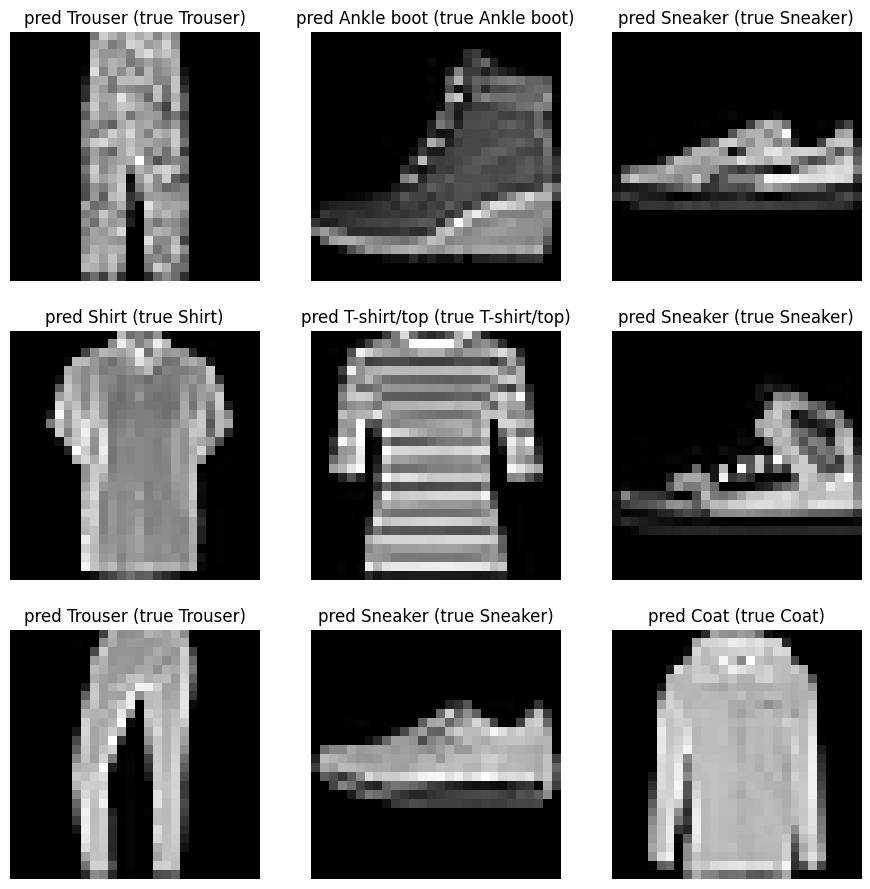

In [51]:
plt.figure(figsize=(11, 11))
rows = 3
cols = 3

for i in range(1, rows * cols + 1):
    plt.subplot(rows, cols, i)
    plt.imshow(test_images[i-1].squeeze(), cmap='gray') #[1, 28, 28] -> [28, 28]
    plt.title(f'pred {train_data.classes[pred_labels[i-1]]} (true {train_data.classes[test_labels[i-1]]})')
    plt.axis(False)

### Make predictions on test data and visualize in confusion matrix

In [52]:
y_preds = [] # list of tensors, where each 32 (batchsize)

model_2.eval()
with torch.inference_mode(): 
    for batch_X, batch_y in test_dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        y_logit = model_2(batch_X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # dim=0 is batch, dim =1 is logit (y_logit.shape = [32, 10])
        y_preds.append(y_pred.cpu())

In [53]:
y_pred.tolist()

[3, 2, 7, 5, 8, 4, 5, 6, 8, 9, 1, 9, 1, 8, 1, 5]

In [54]:
y_preds[:4]

[tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 5, 3, 4, 1, 2, 6, 8, 0, 2, 5, 7, 5,
         1, 6, 6, 0, 9, 3, 8, 8]),
 tensor([3, 3, 8, 0, 7, 5, 7, 9, 0, 1, 0, 7, 6, 7, 2, 1, 4, 6, 4, 2, 5, 8, 2, 2,
         8, 4, 8, 0, 7, 7, 8, 5]),
 tensor([1, 1, 4, 4, 7, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2,
         0, 6, 5, 3, 6, 7, 1, 8]),
 tensor([0, 1, 4, 2, 3, 6, 7, 6, 7, 8, 5, 7, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8,
         0, 0, 9, 9, 3, 0, 8, 4])]

In [55]:
y_pred_tensor = torch.cat(y_preds) # concatinate list of tensors to 1 tensor with 10000 entires
y_pred_tensor.shape, y_pred_tensor

(torch.Size([10000]), tensor([9, 2, 1,  ..., 8, 1, 5]))

In [56]:
test_data.targets.shape, test_data.targets

(torch.Size([10000]), tensor([9, 2, 1,  ..., 8, 1, 5]))

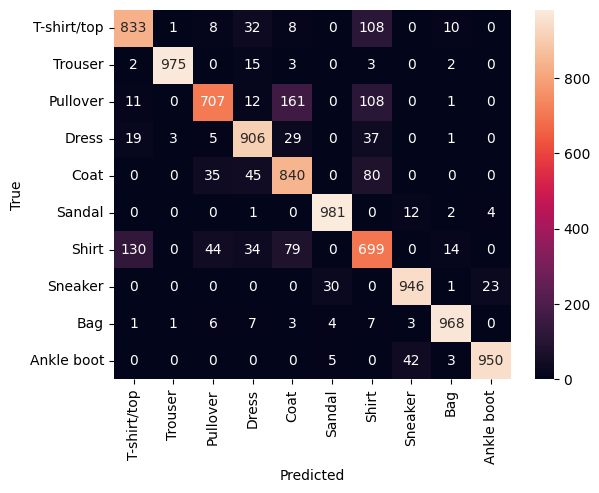

In [57]:
cm = confusion_matrix(test_data.targets, y_pred_tensor)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [58]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

In [59]:
loaded_model_2 = FashionMNISTModelV2(input_shape=1, # same shapes as in saved model
                                    hidden_units=10,
                                    output_shape=10) 

loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
loaded_model_2 = loaded_model_2.to(device)

# Transfer learning

Pretrained model from torchvision.models

In [60]:
from torchvision.models import MobileNetV2, MobileNet_V2_Weights

In [61]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.MobileNet_V2_Weights.DEFAULT # .DEFAULT = best available weights 
model_tl = torchvision.models.mobilenet_v2(weights=weights).to(device)

In [62]:
for param in model_tl.features.parameters():
    param.requires_grad = False

In [63]:
summary(model=model_tl, 
        input_size=(128, 3, 232, 232),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
MobileNetV2 (MobileNetV2)                     [128, 3, 232, 232]   [128, 1000]          --                   Partial
├─Sequential (features)                       [128, 3, 232, 232]   [128, 1280, 8, 8]    --                   False
│    └─Conv2dNormActivation (0)               [128, 3, 232, 232]   [128, 32, 116, 116]  --                   False
│    │    └─Conv2d (0)                        [128, 3, 232, 232]   [128, 32, 116, 116]  (864)                False
│    │    └─BatchNorm2d (1)                   [128, 32, 116, 116]  [128, 32, 116, 116]  (64)                 False
│    │    └─ReLU6 (2)                         [128, 32, 116, 116]  [128, 32, 116, 116]  --                   --
│    └─InvertedResidual (1)                   [128, 32, 116, 116]  [128, 16, 116, 116]  --                   False
│    │    └─Sequential (conv)                 [128, 32, 116, 116]  [128, 16, 

In [64]:
model_tl.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [65]:
# modify classifier
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(train_data.classes)

# recreate the classifier layer, make modifications and seed it to the target device
model_tl.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=False),
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape,
                    bias=True)).to(device)

In [66]:
model_tl.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=10, bias=True)
)

In [70]:

# transform data to fit the model_tf

# ALT 1 Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

# ALT 2 automatic
weights = torchvision.models.MobileNet_V2_Weights.DEFAULT
auto_transforms = weights.transforms() # Get the transforms used to create our pretrained weights

# create dataloaders for test and train with manual tranform or auto transorms

# train model_tf

---

modification of own model (model_2)

In [144]:
model_2_tl = copy.deepcopy(model_2)

In [137]:
# print saved classifier weights and biases for model_2
for name, param in model_2.named_parameters():
    if 'classifier' in name:
        print(f"Layer: {name}")
        print({param.data})

Layer: classifier.1.weight
{tensor([[ 0.0171,  0.1534,  0.1033,  ...,  0.0163,  0.0006, -0.0411],
        [ 0.0133,  0.0583, -0.1066,  ..., -0.0066,  0.0450,  0.0368],
        [-0.0588,  0.0309,  0.0247,  ...,  0.0229, -0.0330, -0.0300],
        ...,
        [-0.0555, -0.1291, -0.1271,  ...,  0.0221,  0.0142, -0.0102],
        [ 0.1196,  0.1989,  0.0744,  ...,  0.0088,  0.0384, -0.0375],
        [-0.0566, -0.1100, -0.0695,  ..., -0.0096, -0.0330,  0.0168]])}
Layer: classifier.1.bias
{tensor([ 0.0647, -0.2147,  0.3844, -0.0823, -0.3874, -0.0690,  0.1545, -0.0018,
         0.2390, -0.1243])}


In [145]:
# print saved classifier weights and biases for model_2-tl
for name, param in model_2_tl.named_parameters():
    if 'classifier' in name:
        print(f"Layer: {name}")
        print({param.data})

Layer: classifier.1.weight
{tensor([[ 0.0171,  0.1534,  0.1033,  ...,  0.0163,  0.0006, -0.0411],
        [ 0.0133,  0.0583, -0.1066,  ..., -0.0066,  0.0450,  0.0368],
        [-0.0588,  0.0309,  0.0247,  ...,  0.0229, -0.0330, -0.0300],
        ...,
        [-0.0555, -0.1291, -0.1271,  ...,  0.0221,  0.0142, -0.0102],
        [ 0.1196,  0.1989,  0.0744,  ...,  0.0088,  0.0384, -0.0375],
        [-0.0566, -0.1100, -0.0695,  ..., -0.0096, -0.0330,  0.0168]])}
Layer: classifier.1.bias
{tensor([ 0.0647, -0.2147,  0.3844, -0.0823, -0.3874, -0.0690,  0.1545, -0.0018,
         0.2390, -0.1243])}


model_2_tl has apparently inhereded weights and biases from model_2 as seen above

In [146]:
# Freeze all base layers
for param in model_2_tl.block_1.parameters():
    param.requires_grad = False

for param in model_2_tl.block_2.parameters():
    param.requires_grad = False

In [147]:
summary(model=model_2_tl, 
        input_size=(32, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
FashionMNISTModelV2 (FashionMNISTModelV2)     [32, 1, 28, 28]      [32, 10]             --                   Partial
├─Sequential (block_1)                        [32, 1, 28, 28]      [32, 10, 14, 14]     --                   False
│    └─Conv2d (0)                             [32, 1, 28, 28]      [32, 10, 28, 28]     (100)                False
│    └─ReLU (1)                               [32, 10, 28, 28]     [32, 10, 28, 28]     --                   --
│    └─Conv2d (2)                             [32, 10, 28, 28]     [32, 10, 28, 28]     (910)                False
│    └─ReLU (3)                               [32, 10, 28, 28]     [32, 10, 28, 28]     --                   --
│    └─MaxPool2d (4)                          [32, 10, 28, 28]     [32, 10, 14, 14]     --                   --
├─Sequential (block_2)                        [32, 10, 14, 14]     [32, 10, 7, 7]  

In [141]:
# current classifier
model_2_tl.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=490, out_features=10, bias=True)
)

In [148]:
# modify classifier
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(train_data.classes)

# recreate the classifier layer, make modifications and seed it to the target device
model_2_tl.classifier = torch.nn.Sequential(
    torch.nn.Flatten(start_dim=1, end_dim=-1),
#   torch.nn.Linear(in_features=490, out_features=490), # added just to test modifying classifier
#   torch.nn.ReLU(),
    torch.nn.Linear(in_features=490, 
                    out_features=output_shape,
                    bias=True)).to(device)

In [ ]:
summary(model=model_2_tl, 
        input_size=(32, 1, 28, 28),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [149]:
# modified classifier
model_2_tl.classifier

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=490, out_features=10, bias=True)
)

In [150]:
# train model with modified classifier
torch.manual_seed(42)
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 3
# Training and validation loop (on test data in this case)
for epoch in range(epochs):
      print(f"Epoch: {epoch}\n---------")
      train_loss, train_accuracy = train_step(data_loader=train_dataloader, model=model_2_tl, loss_fn=loss_fn, optimizer=optimizer, accuracy_fn=accuracy_fn, device=device)
      train_losses.append(train_loss.item())
      train_accuracies.append(train_accuracy.item())
 
      val_loss, val_accuracy = test_step(data_loader=test_dataloader, model=model_2_tl, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)
      val_losses.append(val_loss.item())
      val_accuracies.append(val_accuracy.item())

# test
test_loss, test_accuracy = test_step(data_loader=test_dataloader, model=model_2_tl, loss_fn=loss_fn, accuracy_fn=accuracy_fn, device=device)

Epoch: 0
---------


Train loss: 2.38066 | Train accuracy: 0.058
Test loss: 2.37834 | Test accuracy: 0.060

Epoch: 1
---------
Train loss: 2.38066 | Train accuracy: 0.058
Test loss: 2.37834 | Test accuracy: 0.060

Epoch: 2
---------
Train loss: 2.38066 | Train accuracy: 0.058
Test loss: 2.37834 | Test accuracy: 0.060

Test loss: 2.37834 | Test accuracy: 0.060



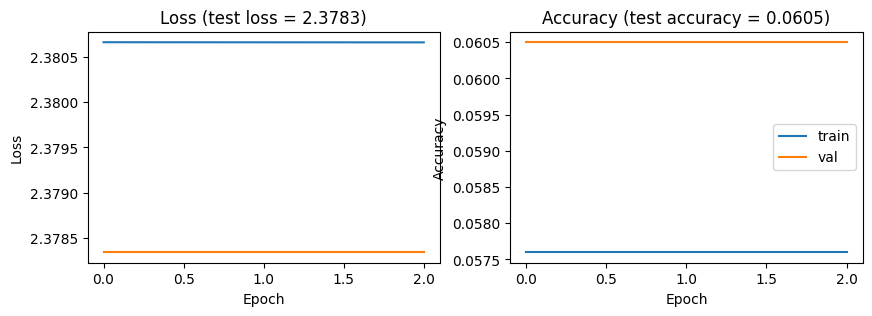

In [151]:
# visualize data
plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies, test_loss, test_accuracy)